# Algorithmic Fairness, Accountability, and Ethics, Spring 2024

## Mandatory Assignment 1

Please use the following code to prepare the dataset.
 

In [2]:
# imports
from folktables.acs import adult_filter
from folktables import ACSDataSource
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt


In [3]:


data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)

feature_names = ['AGEP', # Age
                 "CIT", # Citizenship status
                 'COW', # Class of worker
                 "ENG", # Ability to speak English
                 'SCHL', # Educational attainment
                 'MAR', # Marital status
                 "HINS1", # Insurance through a current or former employer or union
                 "HINS2", # Insurance purchased directly from an insurance company
                 "HINS4", # Medicaid
                 "RAC1P", # Recoded detailed race code
                 'SEX']

target_name = "PINCP" # Total person's income

def data_processing(data, features, target_name:str, threshold: float = 35000):
    df = data
    ### Adult Filter (STARTS) (from Foltktables)
    df = df[~df["SEX"].isnull()]
    df = df[~df["RAC1P"].isnull()]
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    ### Adult Filter (ENDS)
    ### Groups of interest
    sex = df["SEX"].values
    ### Target
    df["target"] = df[target_name] > threshold
    target = df["target"].values
    df = df[features + ["target", target_name]] ##we want to keep df before one_hot encoding to make Bias Analysis
    df_processed = df[features].copy()
    cols = [ "HINS1", "HINS2", "HINS4", "CIT", "COW", "SCHL", "MAR", "SEX", "RAC1P"]
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=False, columns=cols, drop_first=True)
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=True, columns=["ENG"], drop_first=True)
    return df_processed, df, target, sex

data, data_original, target, group = data_processing(acs_data, feature_names, target_name)

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    data, target, group, test_size=0.2, random_state=0)

In [4]:
scaler = MinMaxScaler()
X_train[["AGEP"]] = scaler.fit_transform(X_train[["AGEP"]])
X_test[["AGEP"]] = scaler.fit_transform(X_test[["AGEP"]])

In [5]:
model = LogisticRegression(max_iter=5000, penalty= "l2", C= 0.8497534359086438, tol=1e-4, solver = "saga")
model.fit(X_train, y_train)

LogisticRegression(C=0.8497534359086438, max_iter=5000, solver='saga')

In [6]:
model = make_pipeline(MinMaxScaler(), LogisticRegression(max_iter=5000, penalty= "l2", C= 0.8497534359086438, tol=1e-4, solver = "saga"))
model.fit(X_train, y_train)
predictions = model.predict(X_test)


In [84]:
model.score(X_test, y_test)

0.7696573224644162

In [12]:
print(list(X_test))

X_test.loc[X_test["SEX_2"]]

['AGEP', 'HINS1_2', 'HINS2_2', 'HINS4_2', 'CIT_2', 'CIT_3', 'CIT_4', 'CIT_5', 'COW_2.0', 'COW_3.0', 'COW_4.0', 'COW_5.0', 'COW_6.0', 'COW_7.0', 'COW_8.0', 'SCHL_2.0', 'SCHL_3.0', 'SCHL_4.0', 'SCHL_5.0', 'SCHL_6.0', 'SCHL_7.0', 'SCHL_8.0', 'SCHL_9.0', 'SCHL_10.0', 'SCHL_11.0', 'SCHL_12.0', 'SCHL_13.0', 'SCHL_14.0', 'SCHL_15.0', 'SCHL_16.0', 'SCHL_17.0', 'SCHL_18.0', 'SCHL_19.0', 'SCHL_20.0', 'SCHL_21.0', 'SCHL_22.0', 'SCHL_23.0', 'SCHL_24.0', 'MAR_2', 'MAR_3', 'MAR_4', 'MAR_5', 'SEX_2', 'RAC1P_2', 'RAC1P_3', 'RAC1P_4', 'RAC1P_5', 'RAC1P_6', 'RAC1P_7', 'RAC1P_8', 'RAC1P_9', 'ENG_2.0', 'ENG_3.0', 'ENG_4.0', 'ENG_nan']


,AGEP,HINS1_2,HINS2_2,HINS4_2,CIT_2,CIT_3,CIT_4,CIT_5,COW_2.0,COW_3.0,...,RAC1P_4,RAC1P_5,RAC1P_6,RAC1P_7,RAC1P_8,RAC1P_9,ENG_2.0,ENG_3.0,ENG_4.0,ENG_nan
306289,0.207792,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
173749,0.376623,False,True,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
321914,0.441558,True,True,True,False,False,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
171580,0.376623,True,False,True,False,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
74651,0.454545,False,True,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251021,0.480519,True,True,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
377210,0.415584,False,True,True,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
180418,0.389610,True,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
38489,0.597403,True,False,True,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [85]:
X_test = X_test.reset_index(drop=True)
s2 = X_test.query("SEX_2 == True")
s1 = X_test.query("SEX_2 == False")

true_s1 = []
for i in s1.index:
    true_s1.append(y_test[i])
true_s2 = []
for i in s2.index:
    true_s2.append(y_test[i])

preds_s2 = model.predict(s2)
preds_s1 = model.predict(s1)

statistical_parity = np.mean(preds_s1) - np.mean(preds_s2)
# Compare outcomes across groups
print("Accuracy for group 1: ", accuracy_score(true_s1, preds_s1))
print("Accuracy for group 2: ", accuracy_score(true_s2, preds_s2))
fpr1, tpr1, thresholds1 = roc_curve(true_s1, preds_s1)
fpr2, tpr2, thresholds2 = roc_curve(true_s2, preds_s2)

print('Selection rate for s1: ', np.sum(preds_s1)/len(preds_s1))
print('Selection rate for s2: ', np.sum(preds_s2)/len(preds_s2))
print('Statistical Parity: ', statistical_parity)

Accuracy for group 1:  0.786625284903739
Accuracy for group 2:  0.7507562662057045
Selection rate for s1:  0.642063915426022
Selection rate for s2:  0.5171240276577356
Statistical Parity:  0.12493988776828646


In [86]:
preds_s1 = model.predict_proba(s1)[:,1]
preds_s2 = model.predict_proba(s2)[:,1]

In [90]:
# Calculate the intersections
intersections = []
for i in range(len(fpr1)):
    for j in range(len(fpr2)):
        if fpr1[i] == fpr2[j] and tpr1[i] == tpr2[j]:
            intersections.append((fpr1[i], tpr1[i]))

# Print the intersections
for intersection in intersections:
    print("Intersection point: FPR =", intersection[0], "TPR =", intersection[1])


Intersection point: FPR = 0.0 TPR = 0.0
Intersection point: FPR = 1.0 TPR = 1.0


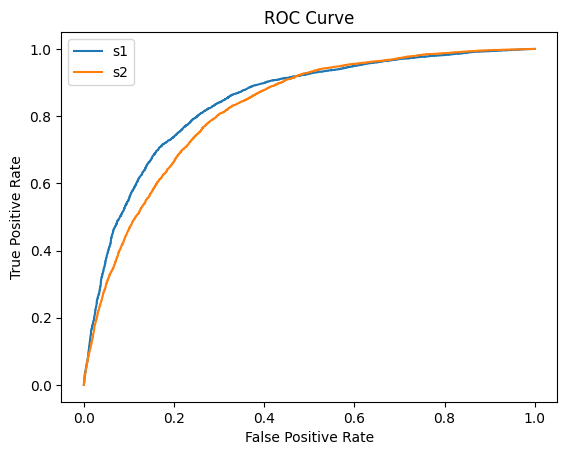

In [91]:
fpr1, tpr1, thresholds1 = roc_curve(true_s1, preds_s1, drop_intermediate=False)
fpr2, tpr2, thresholds2 = roc_curve(true_s2, preds_s2, drop_intermediate=False)

# Plot ROC curve for s1
plt.plot(fpr1, tpr1, label='s1')
# Plot ROC curve for s2
plt.plot(fpr2, tpr2, label='s2')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Show the plot
plt.show()


In [88]:
model.score(X_test, y_test)
# Retrieve the coefficients of the logistic regression model
coefficients = model.coef_[0]
# Compute the odds ratio
odds_ratio = np.exp(coefficients)

std_error = np.std(X_train, axis=0) * coefficients
coefficients_df = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': coefficients, 'Odds Ratio': odds_ratio, 'Std Error': std_error})
# Sort the dataframe by coefficient values in descending order
coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)

# Display the dataframe
coefficients_df

,Feature,Coefficient,Odds Ratio,Std Error
AGEP,AGEP,2.874667,17.719515,0.555925
SCHL_24.0,SCHL_24.0,2.455668,11.654220,0.342627
SCHL_23.0,SCHL_23.0,2.427598,11.331630,0.404595
SCHL_22.0,SCHL_22.0,2.239803,9.391481,0.672871
SCHL_21.0,SCHL_21.0,1.739669,5.695457,0.740836
SCHL_20.0,SCHL_20.0,0.991959,2.696513,0.269792
HINS4_2,HINS4_2,0.835314,2.305539,0.292426
SCHL_19.0,SCHL_19.0,0.705629,2.025120,0.261554
SCHL_18.0,SCHL_18.0,0.657597,1.930148,0.164067
SCHL_17.0,SCHL_17.0,0.615810,1.851155,0.088675
